In [1]:
import numpy as np
from PIL import Image
import os
import math

In [ ]:
def stack_cheat_layers(rgb, root_dir):
    rgb_arr = np.array(Image.open(os.path.join(root_dir, 'rgb', rgb)).convert('RGB'), dtype = np.uint8)
    seg_arr = np.array(Image.open(os.path.join(root_dir, 'rgb_seg', rgb)).convert('L'), dtype = np.uint8)
    seg_arr = np.expand_dims(seg_arr, axis = 2)
    stack = np.concatenate((rgb_arr, seg_arr), axis = 2)
    return stack

# Load image and lidar data and return the stack as a cmyk image (actually rgbd)
def load_image(img_path):
    root_dir = '/'.join(os.path.dirname(img_path).split('/')[:-1])
    rgb = os.path.basename(img_path)
    lidar = os.path.basename(img_path).replace('.png', '.npy')
    # img = Image.fromarray(stack_layers(lidar, rgb, root_dir), mode="CMYK")
    stack_cheat_layers(rgb, root_dir)

load_image('../data_sample/clear_day/rgb/0.png')

(1080, 1920, 3)
(1080, 1920, 1)
(1080, 1920, 4)


In [9]:
def lin_mapping(vector, max_val = 250):
    distance_scaled = np.interp(vector, [0, max_val], [0, 255]).astype(np.uint8)
    return distance_scaled

def log_mapping(vector, max_val = 250):
    log_function = lambda x: 255 * math.log(x + 1) / math.log(max_val + 1)
    distance_scaled = np.vectorize(log_function)(vector).astype(np.uint8)
    return distance_scaled

def to_sparse_depth_image(lidar, w, h):
    VCOORD = 0
    UCOORD = 1
    DISTANCE = 3

    vcoord = lidar[VCOORD].astype(np.uint8)
    ucoord = lidar[UCOORD].astype(np.uint8)

    # distance_cm = (lidar[DISTANCE] * 100).astype(np.uint16)
    distance_scaled = lin_mapping(lidar[DISTANCE], 250)
    # distance_scaled = np.interp(lidar[DISTANCE], [0, 250], [0, 255]).astype(np.uint8)

    distance = np.zeros((h, w), dtype=np.uint8)
    distance[vcoord, ucoord] = distance_scaled
    return np.expand_dims(distance, axis = 2)

def stack_layers(lidar, rgb, root_dir):
    rgb_arr = np.array(Image.open(os.path.join(root_dir, 'rgb', rgb)).convert('RGB'), dtype = np.uint8)
    lidar_arr = np.load(os.path.join(root_dir, 'lidar_2d', lidar))
    distance = to_sparse_depth_image(lidar_arr, rgb_arr.shape[1], rgb_arr.shape[0])

    assert distance.shape[0] == rgb_arr.shape[0] and distance.shape[1] == rgb_arr.shape[1]

    stack = np.concatenate((rgb_arr, distance), axis = 2)
    return stack

def load_image(img_path):
    root_dir = '/'.join(os.path.dirname(img_path).split('/')[:-1])
    rgb = os.path.basename(img_path)
    lidar = os.path.basename(img_path).replace('.png', '.npy')
    img = Image.fromarray(stack_layers(lidar, rgb, root_dir), mode="CMYK")
    return img

stack = load_image('/home/lin/Desktop/fusion/semantic-segmentation-pytorch/data_sample/clear_day/rgb/1.png')

In [12]:
img = np.float32(np.array(stack)) / 255.
img = img.transpose((2, 0, 1))

In [13]:
img.shape

(4, 1080, 1920)

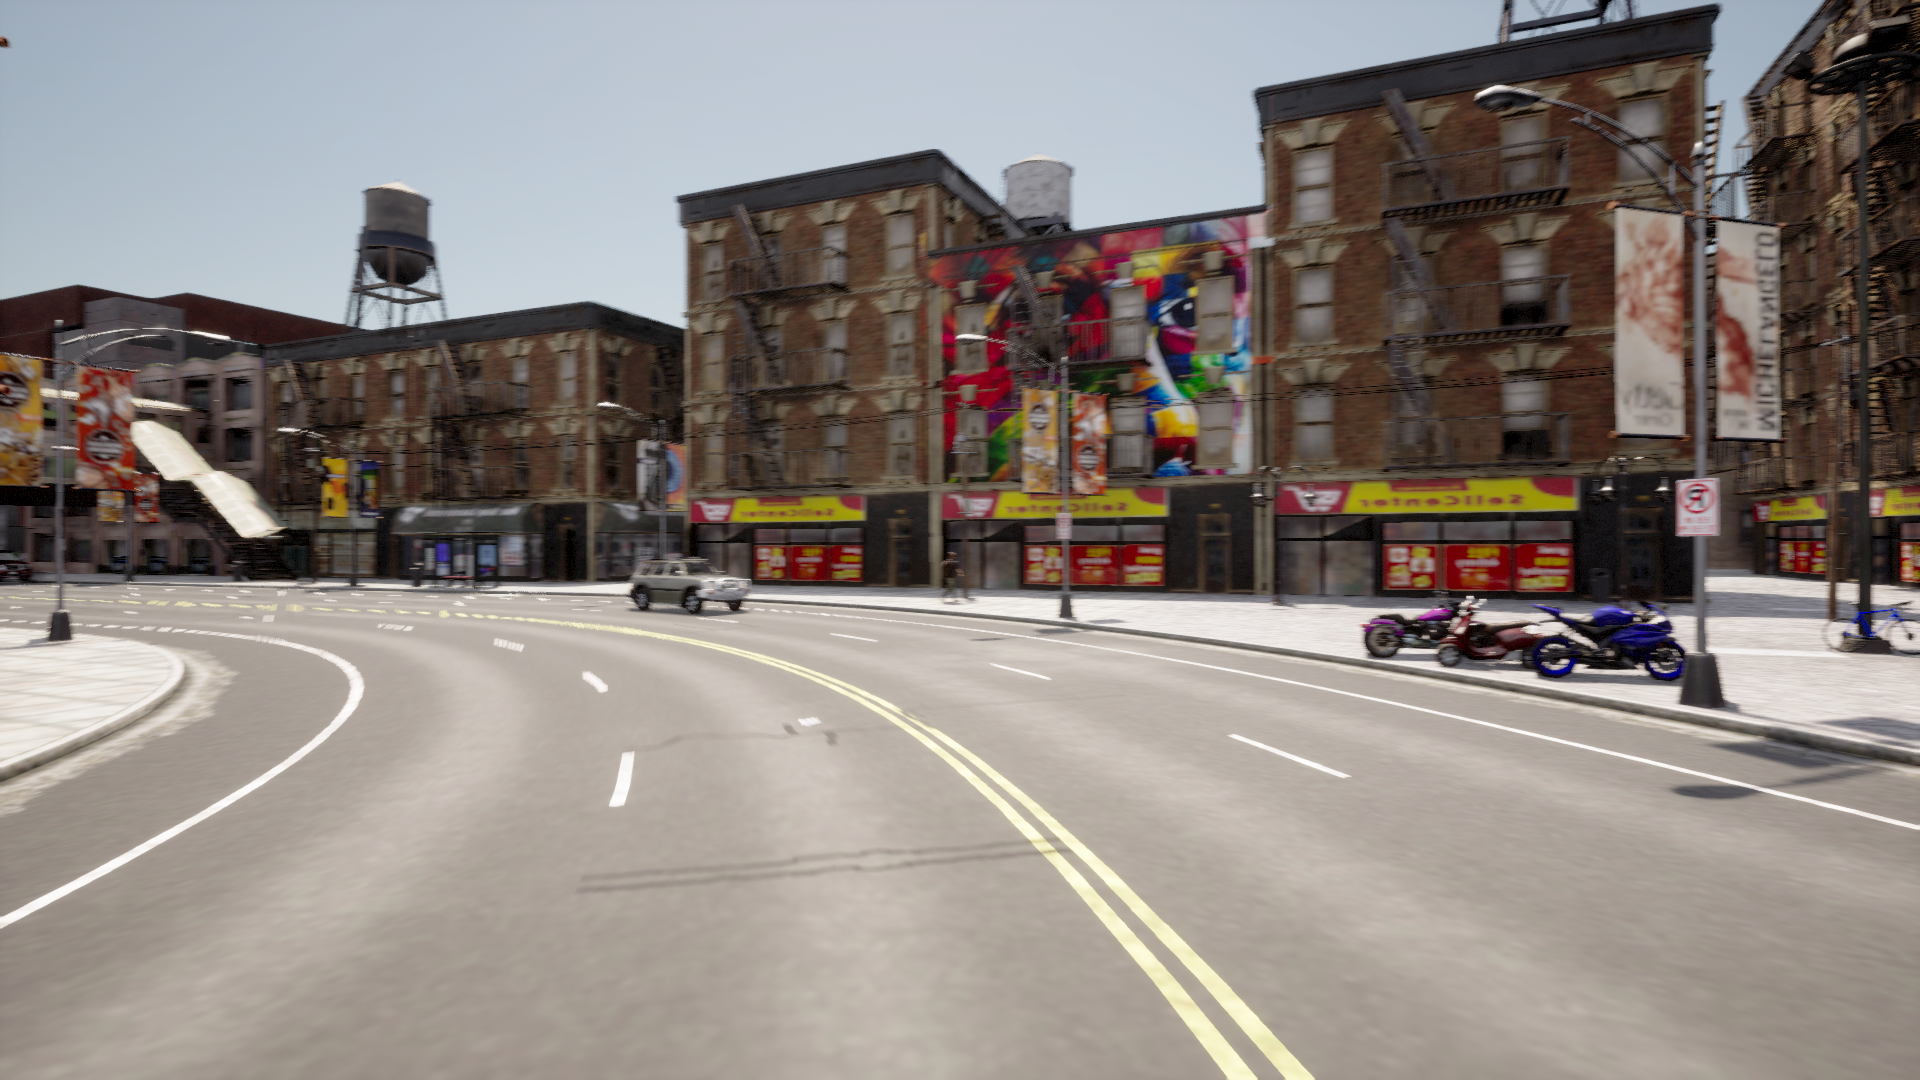

In [27]:
Image.open('/home/lin/Desktop/fusion/semantic-segmentation-pytorch/data_sample/clear_day/rgb/1.png').convert('RGB').transpose(Image.FLIP_LEFT_RIGHT)

In [3]:
root_dir = '/Data/test_lidar/clear_day'
lidar_list = sorted(os.listdir(os.path.join(root_dir, 'lidar_2d')), key = lambda x: int(x.split('.')[0]))
rgb_list = sorted(os.listdir(os.path.join(root_dir, 'rgb')), key = lambda x: int(x.split('.')[0]))[1:] # for some reason rgb starts at 0 and lidar starts at 1
assert len(lidar_list) == len(rgb_list)

In [9]:
def lin_mapping(vector, max_val = 250):
    distance_scaled = np.interp(vector, [0, max_val], [0, 255]).astype(np.uint8)
    return distance_scaled

def log_mapping(vector, max_val = 250):
    log_function = lambda x: 255 * math.log(x + 1) / math.log(max_val + 1)
    distance_scaled = np.vectorize(log_function)(vector).astype(np.uint8)
    return distance_scaled

In [10]:
def to_sparse_depth_image(lidar, w, h):
    VCOORD = 0
    UCOORD = 1
    DISTANCE = 3

    vcoord = lidar[VCOORD].astype(np.uint8)
    ucoord = lidar[UCOORD].astype(np.uint8)

    # distance_cm = (lidar[DISTANCE] * 100).astype(np.uint16)
    distance_scaled = lin_mapping(lidar[DISTANCE], 250)
    # distance_scaled = np.interp(lidar[DISTANCE], [0, 250], [0, 255]).astype(np.uint8)

    distance = np.zeros((h, w), dtype=np.uint8)
    distance[vcoord, ucoord] = distance_scaled
    return np.expand_dims(distance, axis = 2)

In [11]:
def stack_layers(lidar, rgb):
    rgb_arr = np.array(Image.open(os.path.join(root_dir, 'rgb', rgb)).convert('RGB'), dtype = np.uint8)
    lidar_arr = np.load(os.path.join(root_dir, 'lidar_2d', lidar))
    distance = to_sparse_depth_image(lidar_arr, rgb_arr.shape[1], rgb_arr.shape[0])

    assert distance.shape[0] == rgb_arr.shape[0] and distance.shape[1] == rgb_arr.shape[1]

    stack = np.concatenate((rgb_arr, distance), axis = 2)
    return stack

In [12]:
for lidar, rgb in zip(lidar_list[2:], rgb_list[2:]):
    stack = stack_layers(lidar, rgb)
    break

In [13]:
stack[np.where(stack[:,:,3] != 0)][:,3].max()

218